In [1]:
!pip install kaggle --upgrade

In [2]:
pip install visualkeras

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import cv2
import glob as gb
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import visualkeras
from keras.applications import DenseNet121

Tensorflow Version: 2.14.0
Number of GPUs Available: 1


# 1. 데이터 불러오기

In [4]:
train_path = '/content/drive/MyDrive/Colab Notebooks/수업/딥러닝/데이터/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/수업/딥러닝/데이터/test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest',             # Fill mode for new pixels after shifts/rotations
    validation_split=0.2
)

In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
data_path = "/content/drive/MyDrive/Colab Notebooks/수업/딥러닝/데이터"

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(200, 200),
    batch_size=64,
    shuffle=True,
    seed=42,
    class_mode='categorical',
    subset='training'  # 'training'으로 설정하여 학습 데이터 생성기로 사용
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(200, 200),
    batch_size=64,
    class_mode='categorical',
    seed=42,
    subset='validation',  # 'validation'으로 설정하여 검증 데이터 생성기로 사용
)

Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

# 테스트 데이터 로딩
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(200, 200),
    batch_size=64,
    class_mode='categorical'
)

Found 140 images belonging to 2 classes.


# 2.데이터 EDA

##1)클래스별 이미지 수 확인

In [37]:
# 훈련 데이터의 클래스별 이미지 수 확인
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

for i, class_label in enumerate(class_labels):
    count = np.sum(class_counts == i)
    print(f"Number of images in class {class_label}: {count}")

Number of images in class cats: 224
Number of images in class dogs: 223


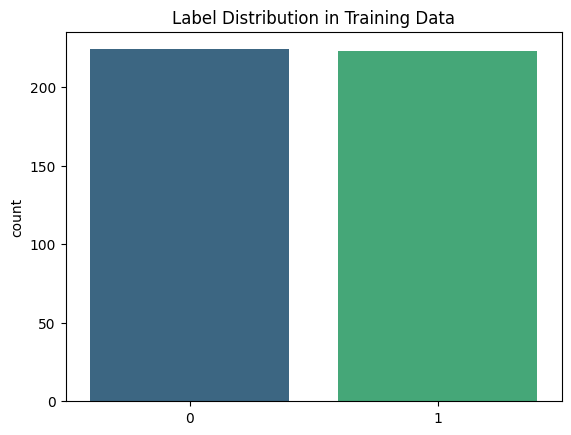

In [38]:
# 훈련 데이터의 라벨 분포 확인
sns.countplot(x=train_generator.classes, palette='viridis')
plt.title('Label Distribution in Training Data')
plt.show()

##2) 이상치 확인

In [42]:
def detect_outliers(images_path, threshold=100):
    outlier_images = []

    for img_file in os.listdir(images_path):
        img_path = os.path.join(images_path, img_file)

        # 이미지 읽기
        img = cv2.imread(img_path)

        # 이미지가 제대로 읽힌 경우에만 이상치 확인
        if img is not None and np.max(img) > threshold:
            outlier_images.append(img_path)

    return outlier_images if outlier_images else None

# 훈련 데이터 경로 설정
train_data_path = os.path.join(data_path, 'train')

# 이상치 확인
outlier_images = detect_outliers(train_data_path)

# 이상치 출력
print("Detected Outlier Images:", outlier_images)

Detected Outlier Images: None


##3)이미지 시각화

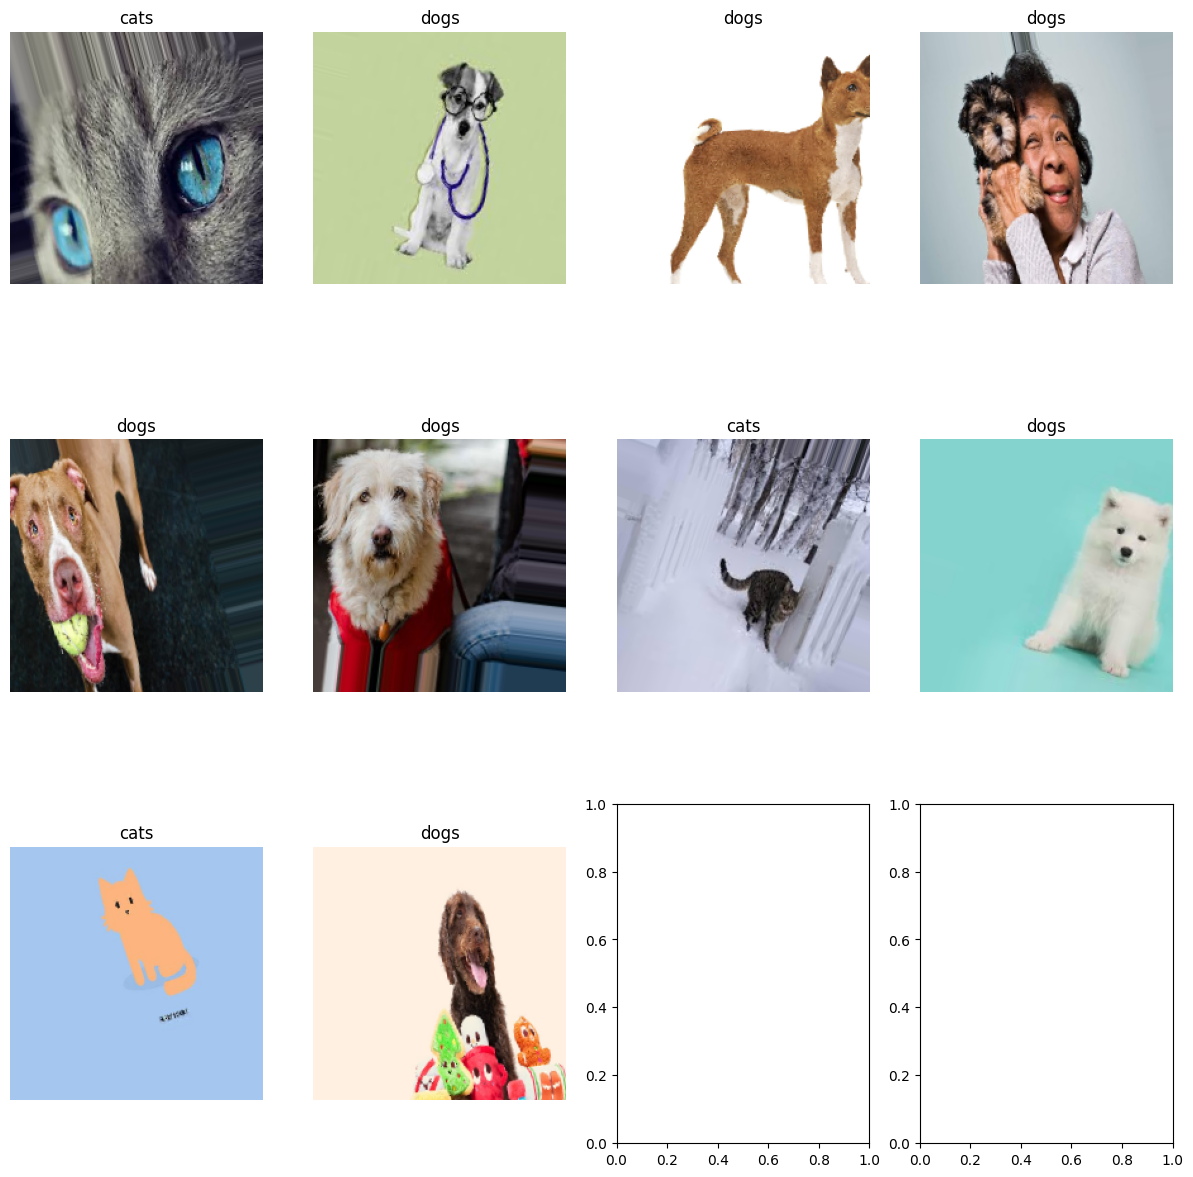

In [41]:
# 이미지를 플로팅하는 함수 정의
def plot_images(images, labels, class_labels, n_cols=4):
    n_rows = len(images) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = axes.flatten()[i]
        ax.imshow(image)
        ax.axis('off')

        # label을 확률 벡터에서 가장 높은 값의 인덱스로 변환
        label_index = np.argmax(label)
        ax.set_title(class_labels[label_index])

    plt.show()

# 훈련 데이터의 일부 이미지 시각화 (첫 번째 배치에서 10개의 이미지만 사용)
sample_images, sample_labels = next(train_generator)
class_labels = list(train_generator.class_indices.keys())
plot_images(sample_images[:10], sample_labels[:10], class_labels)


원래 이미지와 증강된 이미지 비교

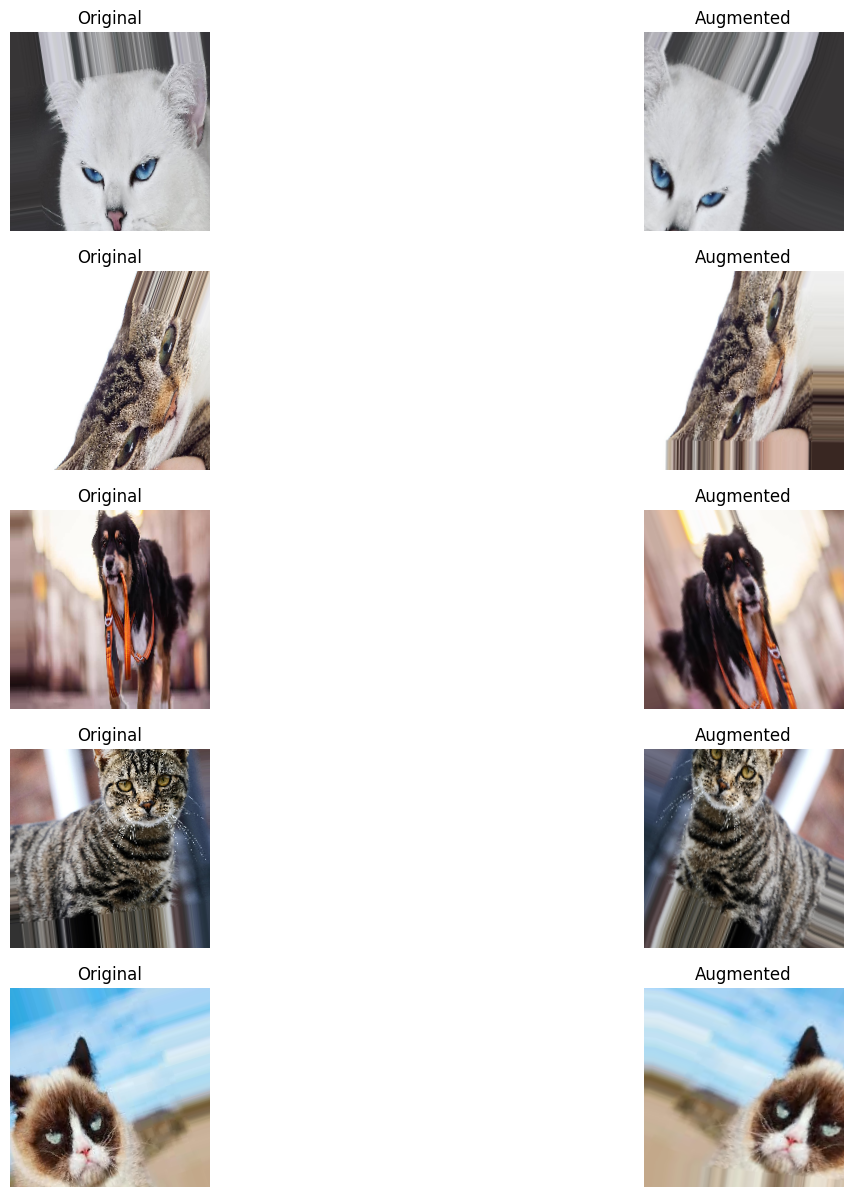

In [ ]:
# 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,  # 랜덤한 각도로 회전
    width_shift_range=0.2,  # 수평으로 랜덤 이동
    height_shift_range=0.2,  # 수직으로 랜덤 이동
    shear_range=0.2,  # 전단 변환
    zoom_range=0.2,  # 랜덤하게 확대 또는 축소
    horizontal_flip=True,  # 수평으로 랜덤하게 뒤집기
    fill_mode='nearest'  # 증강 시 생기는 빈 픽셀을 가장 가까운 픽셀 값으로 채우기
)

# 훈련 데이터에서 한 배치를 가져옴
sample_images, _ = next(train_generator)

# 데이터 증강을 적용하고 증강된 이미지를 플로팅하는 함수
def plot_augmented_images(original_images, datagen, n_cols=2):
    n_rows = len(original_images)
    augmented_images = []

    # 데이터 증강을 적용하고 증강된 이미지를 리스트에 추가
    for i in range(n_rows):
        img = original_images[i]
        img_batch = img.reshape((1,) + img.shape)
        augmented_batch = datagen.flow(img_batch, batch_size=1)
        augmented_image = augmented_batch[0][0]
        augmented_images.append(augmented_image)

    # 원본 이미지와 증강된 이미지를 비교하여 플로팅
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    for i in range(n_rows):
        axes[i, 0].imshow(original_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        axes[i, 1].imshow(augmented_images[i])
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Augmented')

    plt.show()

# 데이터 증강 결과를 시각화
plot_augmented_images(sample_images[0:5], datagen)


# 3.모델링

##1) DenseNet

In [33]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

In [34]:

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [35]:
from tensorflow.keras import optimizers

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.5,
)
from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [36]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [37]:
for layer in base_model.layers:
    layer.trainable = False

In [38]:
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 36864)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               9437440   
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                

In [39]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [40]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [41]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    callbacks=[lr_callback, learning_rate_reduce, early_stopping]
)

Epoch 1/5
6/6 [==============================] - 23s 3s/step - loss: 96.7017 - accuracy: 0.5000 - val_loss: 11.3414 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 2/5
6/6 [==============================] - 12s 2s/step - loss: 19.9365 - accuracy: 0.7546 - val_loss: 7.9961 - val_accuracy: 0.8438 - lr: 0.0099
Epoch 3/5
6/6 [==============================] - 14s 3s/step - loss: 4.5200 - accuracy: 0.8668 - val_loss: 3.1622 - val_accuracy: 0.9062 - lr: 0.0099
Epoch 4/5
6/6 [==============================] - 12s 2s/step - loss: 1.6170 - accuracy: 0.9426 - val_loss: 1.9806 - val_accuracy: 0.9375 - lr: 0.0098
Epoch 5/5
6/6 [==============================] - 9s 2s/step - loss: 1.4042 - accuracy: 0.9373 - val_loss: 1.6907 - val_accuracy: 0.8438 - lr: 0.0098


In [42]:
score = model.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6206425428390503
Test accuracy: 0.8999999761581421


<Figure size 640x480 with 0 Axes>

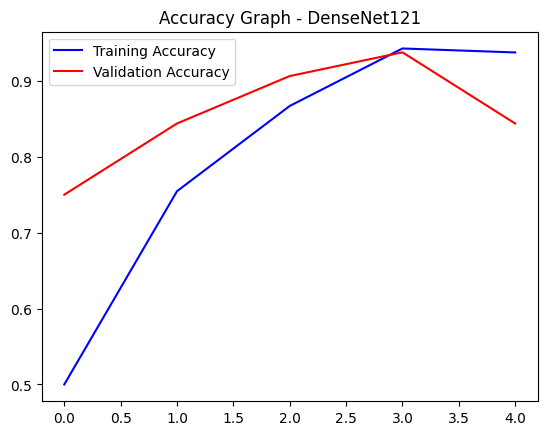

<Figure size 640x480 with 0 Axes>

In [43]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph - DenseNet121')
plt.legend()
plt.figure()

##2) VGG16

In [44]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)


learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.5,
)

from tensorflow.keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lambda epoch, lr: learning_rate_schedule(epoch))
callback=[lr_callback, learning_rate_reduce, early_stopping]

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_vgg16.layers:
    layer.trainable = False

model_vgg16 = tf.keras.models.Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_vgg16.summary()

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
model_vgg16.compile(optimizer=optimizer,
                    loss="categorical_crossentropy",
                    metrics=['accuracy']
                   )

history = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    callbacks=callback
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [45]:
score = model_vgg16.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.6837334632873535
Test accuracy: 0.5


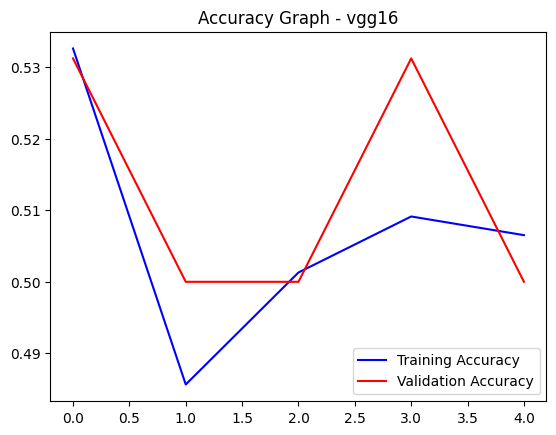

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph - vgg16')
plt.legend()
plt.show()

##3) InceptionV3(GoogleNet)

In [47]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.5,
)

from tensorflow.keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lambda epoch, lr: learning_rate_schedule(epoch))
callback=[lr_callback, learning_rate_reduce, early_stopping]

base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

model_inceptionv3 = tf.keras.models.Sequential([
    base_model_inceptionv3,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_inceptionv3.summary()

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
model_inceptionv3.compile(optimizer=optimizer,
                         loss="categorical_crossentropy",
                         metrics=['accuracy']
                        )

history = model_inceptionv3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    callbacks=callback
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [48]:
score = model_inceptionv3.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.15663309395313263
Test accuracy: 0.9090909361839294


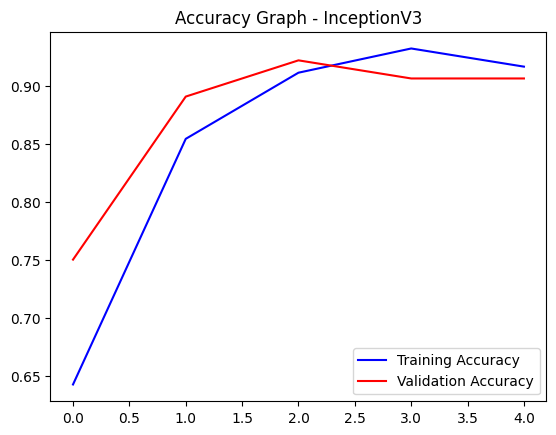

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph - InceptionV3')
plt.legend()
plt.show()

## 4) ResNet50

In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.5,
)

from tensorflow.keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lambda epoch, lr: learning_rate_schedule(epoch))
callback=[lr_callback, learning_rate_reduce, early_stopping]

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_resnet50.layers:
    layer.trainable = False

model_resnet50 = tf.keras.models.Sequential([
    base_model_resnet50,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_resnet50.summary()

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
model_resnet50.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=['accuracy']
                     )

history = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    callbacks=callback
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_24 (Dense)            (None, 256)               524544    
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                      

In [51]:
score = model_resnet50.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.6931174397468567
Test accuracy: 0.5090909004211426


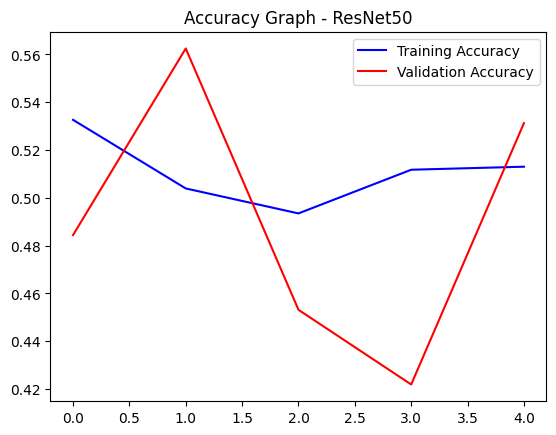

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph - ResNet50')
plt.legend()
plt.show()

##5) MobileNetV2

In [53]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.5,
)

lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[lr_callback, learning_rate_reduce, early_stopping]


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model_mobilenetv2 = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_mobilenetv2.summary()

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
model_mobilenetv2.compile(optimizer=optimizer,
                         loss="categorical_crossentropy",
                         metrics=['accuracy']
                        )

history = model_mobilenetv2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    callbacks=callback
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_28 (Dense)            (None, 256)               327936    
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [54]:
score = model_mobilenetv2.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.40841153264045715
Test accuracy: 0.918181836605072


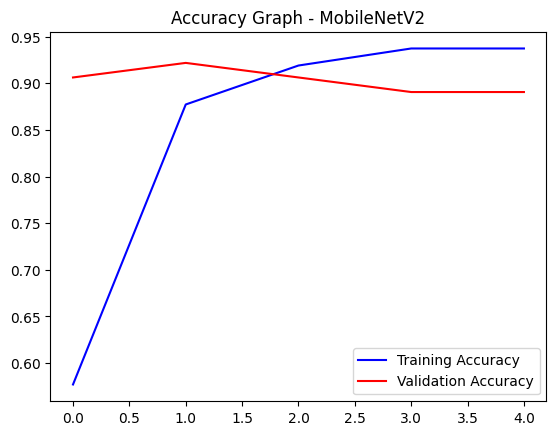

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph - MobileNetV2')
plt.legend()
plt.show()

# 4.모델 성능 개선

- Randomsearch : 지정된 범위 내에서 하이퍼파라미터를 선택

In [56]:
pip install keras-tuner


##1) DenseNet

In [57]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121

def build_model(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units3', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

# Define the search space for hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='tuner_dir',  # Directory to store results
    project_name='densenet_tuning'  # Name of the tuning project
)

# Set up callbacks
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

callbacks = [early_stopping, learning_rate_reduce]

# Perform hyperparameter tuning
tuner.search(train_generator, epochs=5, validation_data=validation_generator, callbacks=callbacks)

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print("Best Hyperparameters:", best_hps)

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from tuner_dir/densenet_tuning/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f77cd91d180>


In [58]:
print("Best Hyperparameters:", best_hps.get_config())


Best Hyperparameters: {'space': [{'class_name': 'Int', 'config': {'name': 'units1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units2', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units3', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}], 'values': {'units1': 320, 'units2': 416, 'units3': 128, 'dropout': 0.2, 'learning_rate': 0.01}}


In [65]:
# Build the final model with the best hyperparameters
final_model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(best_hps.get('units1'), activation='relu'),
    layers.Dense(best_hps.get('units2'), activation='relu'),
    layers.Dense(best_hps.get('units3'), activation='relu'),
    layers.Dropout(best_hps.get('dropout')),
    layers.Dense(2, activation='softmax'),
])

# Compile the model
optimizer = optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
final_model.compile(optimizer=optimizer,
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

# Training the model
history_d121 = final_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 64,
    callbacks=callback
)


Epoch 1/5
6/6 [==============================] - 17s 2s/step - loss: 9.5487 - accuracy: 0.5953 - val_loss: 0.4178 - val_accuracy: 0.7734 - lr: 0.0100
Epoch 2/5
6/6 [==============================] - 14s 2s/step - loss: 0.2318 - accuracy: 0.8982 - val_loss: 0.2290 - val_accuracy: 0.9297 - lr: 0.0100
Epoch 3/5
6/6 [==============================] - 10s 2s/step - loss: 0.2064 - accuracy: 0.9243 - val_loss: 0.2356 - val_accuracy: 0.8984 - lr: 0.0100
Epoch 4/5
6/6 [==============================] - 9s 1s/step - loss: 0.1436 - accuracy: 0.9504 - val_loss: 0.1492 - val_accuracy: 0.9297 - lr: 0.0100
Epoch 5/5
6/6 [==============================] - 9s 2s/step - loss: 0.1204 - accuracy: 0.9556 - val_loss: 0.2419 - val_accuracy: 0.9297 - lr: 0.0100


In [66]:
# Evaluate on test dataset
score = final_model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2558281421661377
Test accuracy: 0.9214285612106323


<Figure size 640x480 with 0 Axes>

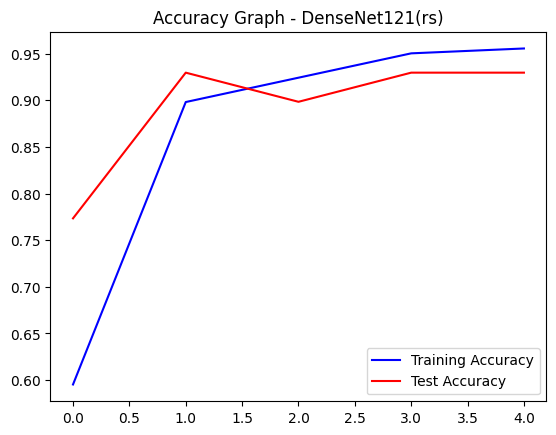

<Figure size 640x480 with 0 Axes>

In [68]:
# Accuracy
acc = history_d121.history['accuracy']
val_acc = history_d121.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.title('Accuracy Graph - DenseNet121(rs)')
plt.legend()
plt.figure()

##2) InceptionV3

In [69]:
def build_model(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units3', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir',
    project_name='inceptionv3_tuning'
)

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

callbacks = [early_stopping, learning_rate_reduce]

tuner.search(train_generator, epochs=5, validation_data=validation_generator, callbacks=callbacks)

best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print("Best Hyperparameters:", best_hps)

final_model = tuner.hypermodel.build(best_hps)


Trial 10 Complete [00h 01m 10s]
val_accuracy: 0.9272727370262146

Best val_accuracy So Far: 0.9636363387107849
Total elapsed time: 00h 13m 11s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f7853892890>


In [70]:
print("Best Hyperparameters:", best_hps.get_config())


Best Hyperparameters: {'space': [{'class_name': 'Int', 'config': {'name': 'units1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units2', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units3', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}], 'values': {'units1': 32, 'units2': 96, 'units3': 448, 'dropout': 0.4, 'learning_rate': 0.001}}


In [71]:
#randomsearch에서 도출된 하이퍼파라미터 결과
best_hps_inceptionv3 = {'units1': 32, 'units2': 96, 'units3': 448, 'dropout': 0.4, 'learning_rate': 0.001}

base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

final_model_inceptionv3 = tf.keras.models.Sequential([
    base_model_inceptionv3,
    GlobalAveragePooling2D(),
    layers.Dense(best_hps_inceptionv3['units1'], activation='relu'),
    layers.Dense(best_hps_inceptionv3['units2'], activation='relu'),
    layers.Dense(best_hps_inceptionv3['units3'], activation='relu'),
    layers.Dropout(best_hps_inceptionv3['dropout']),
    layers.Dense(2, activation='softmax')
])

optimizer_inceptionv3 = optimizers.Adam(learning_rate=best_hps_inceptionv3['learning_rate'])
final_model_inceptionv3.compile(optimizer=optimizer_inceptionv3,
                                loss="categorical_crossentropy",
                                metrics=['accuracy'])

history_inceptionv3 = final_model_inceptionv3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 64,
    callbacks=callback
)


Epoch 1/5
6/6 [==============================] - 18s 2s/step - loss: 6.0216 - accuracy: 0.5431 - val_loss: 1.1207 - val_accuracy: 0.5156 - lr: 0.0100
Epoch 2/5
6/6 [==============================] - 11s 2s/step - loss: 0.5912 - accuracy: 0.5822 - val_loss: 0.4884 - val_accuracy: 0.8203 - lr: 0.0100
Epoch 3/5
6/6 [==============================] - 8s 1s/step - loss: 0.3673 - accuracy: 0.9243 - val_loss: 0.3712 - val_accuracy: 0.9219 - lr: 0.0100
Epoch 4/5
6/6 [==============================] - 9s 2s/step - loss: 0.2444 - accuracy: 0.9219 - val_loss: 0.2724 - val_accuracy: 0.9062 - lr: 0.0100
Epoch 5/5
6/6 [==============================] - 9s 2s/step - loss: 0.1852 - accuracy: 0.9504 - val_loss: 0.3805 - val_accuracy: 0.9141 - lr: 0.0100


In [72]:
# Evaluate on test dataset
score = final_model_inceptionv3.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3730122148990631
Test accuracy: 0.9142857193946838


<Figure size 640x480 with 0 Axes>

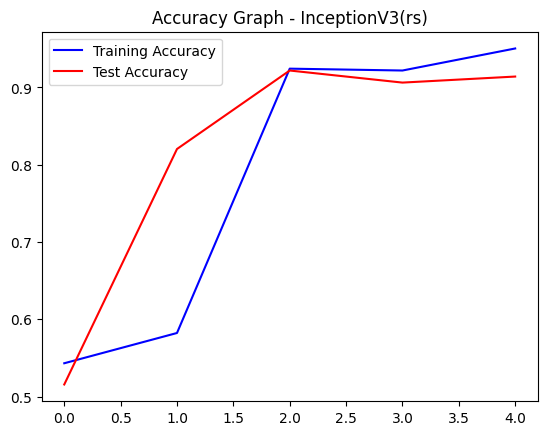

<Figure size 640x480 with 0 Axes>

In [74]:
# Accuracy
acc = history_inceptionv3.history['accuracy']
val_acc = history_inceptionv3.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.title('Accuracy Graph - InceptionV3(rs)')
plt.legend()
plt.figure()

##3) MobileNetV2

In [75]:
def build_model(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        layers.Dense(hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units3', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir',
    project_name='mobilenetv2_tuning'
)

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

callbacks = [early_stopping, learning_rate_reduce]

tuner.search(train_generator, epochs=5, validation_data=validation_generator, callbacks=callbacks)

best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print("Best Hyperparameters:", best_hps)

final_model = tuner.hypermodel.build(best_hps)


Trial 10 Complete [00h 01m 11s]
val_accuracy: 0.9090909361839294

Best val_accuracy So Far: 0.9454545378684998
Total elapsed time: 00h 11m 40s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f779c9d7550>


In [76]:
print("Best Hyperparameters:", best_hps.get_config())


Best Hyperparameters: {'space': [{'class_name': 'Int', 'config': {'name': 'units1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units2', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units3', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}], 'values': {'units1': 224, 'units2': 256, 'units3': 416, 'dropout': 0.30000000000000004, 'learning_rate': 0.001}}


In [77]:
#randomsearch에서 도출된 하이퍼파라미터 결과
best_hps_mobilenetv2 = {'units1': 224, 'units2': 256, 'units3': 416, 'dropout': 0.3, 'learning_rate': 0.001}

base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_mobilenetv2.layers:
    layer.trainable = False

final_model_mobilenetv2 = tf.keras.models.Sequential([
    base_model_mobilenetv2,
    GlobalAveragePooling2D(),
    layers.Dense(best_hps_mobilenetv2['units1'], activation='relu'),
    layers.Dense(best_hps_mobilenetv2['units2'], activation='relu'),
    layers.Dense(best_hps_mobilenetv2['units3'], activation='relu'),
    layers.Dropout(best_hps_mobilenetv2['dropout']),
    layers.Dense(2, activation='softmax')
])

optimizer_mobilenetv2 = optimizers.Adam(learning_rate=best_hps_mobilenetv2['learning_rate'])
final_model_mobilenetv2.compile(optimizer=optimizer_mobilenetv2,
                                loss="categorical_crossentropy",
                                metrics=['accuracy'])

history_mobilenetv2 = final_model_mobilenetv2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 64,
    callbacks=callback
)


Epoch 1/5
6/6 [==============================] - 19s 3s/step - loss: 8.8683 - accuracy: 0.5692 - val_loss: 0.4195 - val_accuracy: 0.8203 - lr: 0.0100
Epoch 2/5
6/6 [==============================] - 10s 2s/step - loss: 0.4903 - accuracy: 0.7911 - val_loss: 0.2997 - val_accuracy: 0.8984 - lr: 0.0100
Epoch 3/5
6/6 [==============================] - 9s 2s/step - loss: 0.1886 - accuracy: 0.9243 - val_loss: 0.1752 - val_accuracy: 0.9297 - lr: 0.0100
Epoch 4/5
6/6 [==============================] - 7s 1s/step - loss: 0.1670 - accuracy: 0.9295 - val_loss: 0.2685 - val_accuracy: 0.8906 - lr: 0.0100
Epoch 5/5
6/6 [==============================] - 10s 2s/step - loss: 0.1393 - accuracy: 0.9375 - val_loss: 0.3747 - val_accuracy: 0.8594 - lr: 0.0100


In [78]:
score = final_model_mobilenetv2.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35783815383911133
Test accuracy: 0.8642857074737549


<Figure size 640x480 with 0 Axes>

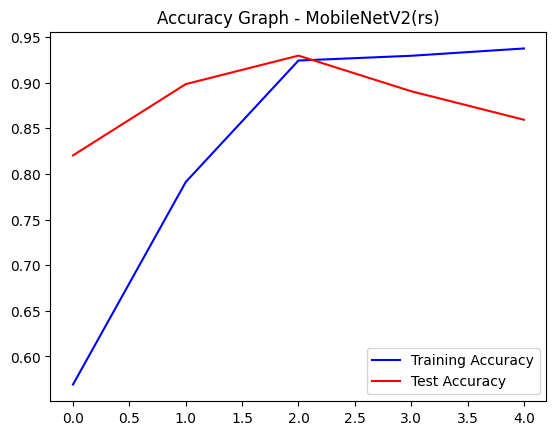

<Figure size 640x480 with 0 Axes>

In [79]:
acc = history_mobilenetv2.history['accuracy']
val_acc = history_mobilenetv2.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.title('Accuracy Graph - MobileNetV2(rs)')
plt.legend()
plt.figure()